In [18]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from torchvision.datasets import ImageFolder

In [4]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [97]:
class Config():
    training_dir = "./partitioned_data/authors/train"
    testing_dir = "./partitioned_data/authors/val"
    train_batch_size = 64
    train_number_epochs = 100

In [98]:
class SiameseNetworkDataset(Dataset):

    def __init__(self, image_folder_dataset: ImageFolder):
        self.image_folder_dataset = image_folder_dataset

    def __getitem__(self, index):
        img_0, class_0 = self.image_folder_dataset[index]

        # Ensure about 50% of images are from same class
        should_get_same_class = random.randint(0, 1)
        while True:
            random_index = random.randrange(0, len(self.image_folder_dataset))
            if random_index == index:
                continue

            img_1, class_1 = self.image_folder_dataset[random_index]

            if should_get_same_class == (class_0 == class_1):
                break

        return img_0, img_1, torch.Tensor([should_get_same_class])

    def __len__(self):
        return len(self.image_folder_dataset.imgs)

In [114]:
folder_dataset = dset.ImageFolder(root=Config.training_dir,
                                 transform=transforms.Compose([
                                     transforms.Resize((100,100)),
                                     transforms.ToTensor(),
#                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                 ]))

In [115]:
siamese_dataset = SiameseNetworkDataset(folder_dataset)

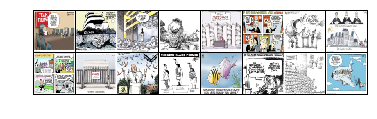

[[0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]]


In [116]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [123]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [124]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [125]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [126]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [127]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.9154942035675049

Epoch number 0
 Current loss 1.3941564559936523

Epoch number 0
 Current loss 1.4865909814834595

Epoch number 0
 Current loss 1.2630572319030762

Epoch number 0
 Current loss 0.99850994348526

Epoch number 0
 Current loss 1.1727259159088135

Epoch number 0
 Current loss 1.453805923461914

Epoch number 0
 Current loss 1.4102458953857422

Epoch number 0
 Current loss 1.595479965209961

Epoch number 0
 Current loss 1.2163617610931396

Epoch number 0
 Current loss 1.1695908308029175

Epoch number 0
 Current loss 1.1534069776535034

Epoch number 0
 Current loss 1.0973255634307861

Epoch number 0
 Current loss 1.1086376905441284

Epoch number 0
 Current loss 1.3898324966430664

Epoch number 0
 Current loss 1.2602039575576782

Epoch number 0
 Current loss 1.0804044008255005

Epoch number 0
 Current loss 1.1956710815429688

Epoch number 0
 Current loss 1.216261386871338

Epoch number 0
 Current loss 1.1161426305770874

Epoch number 0
 Current l

Epoch number 4
 Current loss 1.0041992664337158

Epoch number 4
 Current loss 1.0791566371917725

Epoch number 4
 Current loss 1.0758951902389526

Epoch number 4
 Current loss 1.0419354438781738

Epoch number 4
 Current loss 1.0551707744598389

Epoch number 4
 Current loss 1.1245708465576172

Epoch number 4
 Current loss 1.0822138786315918

Epoch number 4
 Current loss 1.0332804918289185

Epoch number 4
 Current loss 1.08931565284729

Epoch number 4
 Current loss 1.1841514110565186

Epoch number 4
 Current loss 1.1123160123825073

Epoch number 4
 Current loss 1.1357309818267822

Epoch number 4
 Current loss 1.1253578662872314

Epoch number 4
 Current loss 1.0633968114852905

Epoch number 4
 Current loss 1.134162425994873

Epoch number 4
 Current loss 0.9868941903114319

Epoch number 4
 Current loss 1.1722989082336426

Epoch number 4
 Current loss 1.0210628509521484

Epoch number 4
 Current loss 1.1242581605911255

Epoch number 4
 Current loss 1.238828182220459

Epoch number 4
 Current 

Epoch number 8
 Current loss 1.3189985752105713

Epoch number 8
 Current loss 1.1489431858062744

Epoch number 8
 Current loss 1.114038348197937

Epoch number 8
 Current loss 1.0644824504852295

Epoch number 8
 Current loss 1.1959422826766968

Epoch number 8
 Current loss 1.2353142499923706

Epoch number 8
 Current loss 1.159181833267212

Epoch number 8
 Current loss 1.1993955373764038

Epoch number 8
 Current loss 0.9904868602752686

Epoch number 8
 Current loss 1.2055888175964355

Epoch number 8
 Current loss 1.1083648204803467

Epoch number 8
 Current loss 1.2383487224578857

Epoch number 8
 Current loss 1.100364327430725

Epoch number 8
 Current loss 1.122812032699585

Epoch number 9
 Current loss 0.952410101890564

Epoch number 9
 Current loss 1.2006263732910156

Epoch number 9
 Current loss 1.2141788005828857

Epoch number 9
 Current loss 1.095757246017456

Epoch number 9
 Current loss 1.1547834873199463

Epoch number 9
 Current loss 1.092604398727417

Epoch number 9
 Current los

Epoch number 12
 Current loss 1.2162262201309204

Epoch number 12
 Current loss 0.8936259746551514

Epoch number 12
 Current loss 0.9405577182769775

Epoch number 12
 Current loss 1.101356029510498

Epoch number 13
 Current loss 1.1880618333816528

Epoch number 13
 Current loss 1.1304649114608765

Epoch number 13
 Current loss 1.079493761062622

Epoch number 13
 Current loss 1.1267979145050049

Epoch number 13
 Current loss 1.2300224304199219

Epoch number 13
 Current loss 1.1203904151916504

Epoch number 13
 Current loss 0.86811763048172

Epoch number 13
 Current loss 1.0471540689468384

Epoch number 13
 Current loss 1.078026294708252

Epoch number 13
 Current loss 1.1341333389282227

Epoch number 13
 Current loss 1.1234909296035767

Epoch number 13
 Current loss 1.1687374114990234

Epoch number 13
 Current loss 1.1369688510894775

Epoch number 13
 Current loss 1.1776618957519531

Epoch number 13
 Current loss 1.2114570140838623

Epoch number 13
 Current loss 1.0793057680130005

Epoch

Epoch number 17
 Current loss 1.1677234172821045

Epoch number 17
 Current loss 1.0378971099853516

Epoch number 17
 Current loss 1.1413919925689697

Epoch number 17
 Current loss 1.1397192478179932

Epoch number 17
 Current loss 1.0746192932128906

Epoch number 17
 Current loss 1.0992498397827148

Epoch number 17
 Current loss 1.051492691040039

Epoch number 17
 Current loss 1.0269651412963867

Epoch number 17
 Current loss 1.013025164604187

Epoch number 17
 Current loss 1.2259013652801514

Epoch number 17
 Current loss 1.0688997507095337

Epoch number 17
 Current loss 1.094939112663269

Epoch number 17
 Current loss 1.092559576034546

Epoch number 17
 Current loss 1.0301316976547241

Epoch number 17
 Current loss 1.0131292343139648

Epoch number 17
 Current loss 1.0883550643920898

Epoch number 17
 Current loss 1.0993518829345703

Epoch number 17
 Current loss 1.1694648265838623

Epoch number 17
 Current loss 1.0772652626037598

Epoch number 17
 Current loss 1.1161189079284668

Epoc

Epoch number 21
 Current loss 1.225376009941101

Epoch number 21
 Current loss 1.1141571998596191

Epoch number 21
 Current loss 1.0292201042175293

Epoch number 21
 Current loss 1.273528814315796

Epoch number 21
 Current loss 0.944373607635498

Epoch number 21
 Current loss 1.0301395654678345

Epoch number 21
 Current loss 0.9963333606719971

Epoch number 21
 Current loss 1.0967857837677002

Epoch number 21
 Current loss 1.099409818649292

Epoch number 21
 Current loss 1.155656099319458

Epoch number 21
 Current loss 1.1916476488113403

Epoch number 21
 Current loss 1.0108312368392944

Epoch number 21
 Current loss 1.1119790077209473

Epoch number 21
 Current loss 1.1755104064941406

Epoch number 21
 Current loss 1.0978312492370605

Epoch number 21
 Current loss 1.0777602195739746

Epoch number 21
 Current loss 1.309761643409729

Epoch number 21
 Current loss 1.1205739974975586

Epoch number 21
 Current loss 1.131864309310913

Epoch number 21
 Current loss 1.1307556629180908

Epoch n

Epoch number 25
 Current loss 1.0500560998916626

Epoch number 25
 Current loss 1.1433162689208984

Epoch number 25
 Current loss 1.0263729095458984

Epoch number 25
 Current loss 1.071367621421814

Epoch number 25
 Current loss 1.0823371410369873

Epoch number 25
 Current loss 1.2006785869598389

Epoch number 25
 Current loss 1.2386412620544434

Epoch number 25
 Current loss 1.2499374151229858

Epoch number 25
 Current loss 0.9973628520965576

Epoch number 25
 Current loss 1.1630443334579468

Epoch number 25
 Current loss 1.040196418762207

Epoch number 25
 Current loss 1.0117822885513306

Epoch number 25
 Current loss 1.1150994300842285

Epoch number 25
 Current loss 1.0759284496307373

Epoch number 25
 Current loss 1.1396229267120361

Epoch number 25
 Current loss 1.0998262166976929

Epoch number 26
 Current loss 1.0557897090911865

Epoch number 26
 Current loss 1.2835805416107178

Epoch number 26
 Current loss 1.1186155080795288

Epoch number 26
 Current loss 1.0936076641082764

Ep

Epoch number 29
 Current loss 1.0099523067474365

Epoch number 29
 Current loss 1.148536205291748

Epoch number 29
 Current loss 1.0909717082977295

Epoch number 29
 Current loss 0.9795608520507812

Epoch number 29
 Current loss 1.0803766250610352

Epoch number 29
 Current loss 1.0252230167388916

Epoch number 29
 Current loss 1.1424250602722168

Epoch number 30
 Current loss 1.1448619365692139

Epoch number 30
 Current loss 1.091023325920105

Epoch number 30
 Current loss 1.079116940498352

Epoch number 30
 Current loss 1.0345938205718994

Epoch number 30
 Current loss 1.136881709098816

Epoch number 30
 Current loss 1.1018706560134888

Epoch number 30
 Current loss 1.0697662830352783

Epoch number 30
 Current loss 1.134997844696045

Epoch number 30
 Current loss 1.1793357133865356

Epoch number 30
 Current loss 0.996721625328064

Epoch number 30
 Current loss 1.0657142400741577

Epoch number 30
 Current loss 1.1902809143066406

Epoch number 30
 Current loss 1.1554011106491089

Epoch 

Epoch number 34
 Current loss 1.0012519359588623

Epoch number 34
 Current loss 1.1346114873886108

Epoch number 34
 Current loss 1.0779063701629639

Epoch number 34
 Current loss 1.0409389734268188

Epoch number 34
 Current loss 1.1222295761108398

Epoch number 34
 Current loss 0.9372167587280273

Epoch number 34
 Current loss 1.0453441143035889

Epoch number 34
 Current loss 1.1646928787231445

Epoch number 34
 Current loss 1.1705751419067383

Epoch number 34
 Current loss 1.1460518836975098

Epoch number 34
 Current loss 0.994330883026123

Epoch number 34
 Current loss 1.1549344062805176

Epoch number 34
 Current loss 1.0355335474014282

Epoch number 34
 Current loss 1.1660566329956055

Epoch number 34
 Current loss 1.028303623199463

Epoch number 34
 Current loss 1.165091872215271

Epoch number 34
 Current loss 1.2565562725067139

Epoch number 34
 Current loss 0.9707527160644531

Epoch number 34
 Current loss 1.1288235187530518

Epoch number 34
 Current loss 1.2492294311523438

Epo

Epoch number 38
 Current loss 1.0510227680206299

Epoch number 38
 Current loss 1.0647118091583252

Epoch number 38
 Current loss 1.0620737075805664

Epoch number 38
 Current loss 1.1223094463348389

Epoch number 38
 Current loss 1.1107239723205566

Epoch number 38
 Current loss 1.1473114490509033

Epoch number 38
 Current loss 1.1277148723602295

Epoch number 38
 Current loss 0.9952434301376343

Epoch number 38
 Current loss 1.0802377462387085

Epoch number 38
 Current loss 1.1748840808868408

Epoch number 38
 Current loss 1.1170885562896729

Epoch number 38
 Current loss 1.0740634202957153

Epoch number 38
 Current loss 1.1734023094177246

Epoch number 38
 Current loss 1.1600217819213867

Epoch number 38
 Current loss 1.0855727195739746

Epoch number 38
 Current loss 1.082535982131958

Epoch number 38
 Current loss 1.134311318397522

Epoch number 38
 Current loss 1.064619779586792

Epoch number 38
 Current loss 0.9462022185325623

Epoch number 38
 Current loss 1.0858479738235474

Epo

Epoch number 42
 Current loss 1.0901691913604736

Epoch number 42
 Current loss 1.0063269138336182

Epoch number 42
 Current loss 1.1724032163619995

Epoch number 42
 Current loss 1.2795754671096802

Epoch number 42
 Current loss 1.0640746355056763

Epoch number 42
 Current loss 1.1359574794769287

Epoch number 42
 Current loss 1.0363035202026367

Epoch number 42
 Current loss 1.0418213605880737

Epoch number 42
 Current loss 1.0018517971038818

Epoch number 42
 Current loss 1.1815719604492188

Epoch number 42
 Current loss 1.1107172966003418

Epoch number 42
 Current loss 1.0138635635375977

Epoch number 42
 Current loss 1.2052011489868164

Epoch number 42
 Current loss 1.13065767288208

Epoch number 42
 Current loss 1.0401512384414673

Epoch number 42
 Current loss 1.0394057035446167

Epoch number 42
 Current loss 1.030325174331665

Epoch number 42
 Current loss 1.0766198635101318

Epoch number 42
 Current loss 1.0285604000091553

Epoch number 43
 Current loss 1.1475038528442383

Epo

Epoch number 46
 Current loss 1.0233869552612305

Epoch number 46
 Current loss 1.1931015253067017

Epoch number 46
 Current loss 1.0887891054153442

Epoch number 46
 Current loss 1.168005347251892

Epoch number 46
 Current loss 1.0941675901412964

Epoch number 46
 Current loss 1.141299843788147

Epoch number 46
 Current loss 0.9879597425460815

Epoch number 46
 Current loss 1.0905543565750122

Epoch number 46
 Current loss 1.0637807846069336

Epoch number 46
 Current loss 1.1522936820983887

Epoch number 47
 Current loss 1.2033973932266235

Epoch number 47
 Current loss 1.1824774742126465

Epoch number 47
 Current loss 1.157155990600586

Epoch number 47
 Current loss 0.911300003528595

Epoch number 47
 Current loss 1.0896978378295898

Epoch number 47
 Current loss 1.0694361925125122

Epoch number 47
 Current loss 1.083097219467163

Epoch number 47
 Current loss 1.08082914352417

Epoch number 47
 Current loss 0.9989758729934692

Epoch number 47
 Current loss 1.0070593357086182

Epoch n

Epoch number 50
 Current loss 1.065230369567871

Epoch number 51
 Current loss 1.0836925506591797

Epoch number 51
 Current loss 1.0807056427001953

Epoch number 51
 Current loss 1.121333360671997

Epoch number 51
 Current loss 1.0156981945037842

Epoch number 51
 Current loss 1.1305468082427979

Epoch number 51
 Current loss 1.135900855064392

Epoch number 51
 Current loss 1.1663024425506592

Epoch number 51
 Current loss 1.015762209892273

Epoch number 51
 Current loss 1.0996500253677368

Epoch number 51
 Current loss 1.0696308612823486

Epoch number 51
 Current loss 1.065140724182129

Epoch number 51
 Current loss 1.020431399345398

Epoch number 51
 Current loss 1.1944808959960938

Epoch number 51
 Current loss 1.0347583293914795

Epoch number 51
 Current loss 1.095374584197998

Epoch number 51
 Current loss 1.1753181219100952

Epoch number 51
 Current loss 1.1272239685058594

Epoch number 51
 Current loss 1.110870599746704

Epoch number 51
 Current loss 1.0261731147766113

Epoch nu

Epoch number 55
 Current loss 0.9768064022064209

Epoch number 55
 Current loss 0.9888845086097717

Epoch number 55
 Current loss 1.1520709991455078

Epoch number 55
 Current loss 1.0927460193634033

Epoch number 55
 Current loss 1.0512217283248901

Epoch number 55
 Current loss 1.0970969200134277

Epoch number 55
 Current loss 1.1933436393737793

Epoch number 55
 Current loss 1.0528771877288818

Epoch number 55
 Current loss 0.9918469190597534

Epoch number 55
 Current loss 1.1034282445907593

Epoch number 55
 Current loss 1.0319441556930542

Epoch number 55
 Current loss 1.07662034034729

Epoch number 55
 Current loss 1.0257024765014648

Epoch number 55
 Current loss 1.1584789752960205

Epoch number 55
 Current loss 1.1201815605163574

Epoch number 55
 Current loss 1.2636252641677856

Epoch number 55
 Current loss 1.086829662322998

Epoch number 55
 Current loss 1.2635616064071655

Epoch number 55
 Current loss 1.258292555809021

Epoch number 55
 Current loss 1.1502397060394287

Epoc

Epoch number 59
 Current loss 1.143237590789795

Epoch number 59
 Current loss 0.943297266960144

Epoch number 59
 Current loss 1.1167540550231934

Epoch number 59
 Current loss 1.08420729637146

Epoch number 59
 Current loss 1.1000038385391235

Epoch number 59
 Current loss 1.0399103164672852

Epoch number 59
 Current loss 1.1742497682571411

Epoch number 59
 Current loss 1.102400779724121

Epoch number 59
 Current loss 1.039901852607727

Epoch number 59
 Current loss 1.1663331985473633

Epoch number 59
 Current loss 1.1103346347808838

Epoch number 59
 Current loss 0.9723312258720398

Epoch number 59
 Current loss 1.3036646842956543

Epoch number 59
 Current loss 1.1206345558166504

Epoch number 59
 Current loss 1.0284059047698975

Epoch number 59
 Current loss 0.8958452343940735

Epoch number 59
 Current loss 1.0563850402832031

Epoch number 59
 Current loss 1.0718302726745605

Epoch number 59
 Current loss 0.9625828266143799

Epoch number 59
 Current loss 1.0993244647979736

Epoch 

Epoch number 63
 Current loss 1.23965585231781

Epoch number 63
 Current loss 1.0556864738464355

Epoch number 63
 Current loss 1.0830066204071045

Epoch number 63
 Current loss 1.244844675064087

Epoch number 63
 Current loss 1.0021255016326904

Epoch number 63
 Current loss 1.0516140460968018

Epoch number 63
 Current loss 1.1121100187301636

Epoch number 63
 Current loss 0.9949841499328613

Epoch number 63
 Current loss 1.2184064388275146

Epoch number 63
 Current loss 1.0268605947494507

Epoch number 63
 Current loss 1.0050625801086426

Epoch number 63
 Current loss 1.048406720161438

Epoch number 63
 Current loss 0.9578750133514404

Epoch number 64
 Current loss 1.198480486869812

Epoch number 64
 Current loss 1.042694091796875

Epoch number 64
 Current loss 1.0646250247955322

Epoch number 64
 Current loss 0.993309497833252

Epoch number 64
 Current loss 1.0579739809036255

Epoch number 64
 Current loss 1.0347071886062622

Epoch number 64
 Current loss 1.142714262008667

Epoch nu

Epoch number 67
 Current loss 1.0723038911819458

Epoch number 67
 Current loss 1.0635910034179688

Epoch number 67
 Current loss 0.984083890914917

Epoch number 67
 Current loss 1.1840271949768066

Epoch number 68
 Current loss 1.2523975372314453

Epoch number 68
 Current loss 1.0265142917633057

Epoch number 68
 Current loss 1.1441912651062012

Epoch number 68
 Current loss 1.0254262685775757

Epoch number 68
 Current loss 1.0809776782989502

Epoch number 68
 Current loss 1.0482897758483887

Epoch number 68
 Current loss 1.0502381324768066

Epoch number 68
 Current loss 1.2573091983795166

Epoch number 68
 Current loss 1.0015029907226562

Epoch number 68
 Current loss 1.0680334568023682

Epoch number 68
 Current loss 1.075439214706421

Epoch number 68
 Current loss 1.1167402267456055

Epoch number 68
 Current loss 1.2528047561645508

Epoch number 68
 Current loss 1.1121882200241089

Epoch number 68
 Current loss 1.0512728691101074

Epoch number 68
 Current loss 1.1063786745071411

Ep

Epoch number 72
 Current loss 1.0221529006958008

Epoch number 72
 Current loss 1.162729263305664

Epoch number 72
 Current loss 1.1746248006820679

Epoch number 72
 Current loss 1.0496551990509033

Epoch number 72
 Current loss 0.9760515093803406

Epoch number 72
 Current loss 1.1230695247650146

Epoch number 72
 Current loss 1.0597203969955444

Epoch number 72
 Current loss 1.0722427368164062

Epoch number 72
 Current loss 1.1563704013824463

Epoch number 72
 Current loss 1.135972499847412

Epoch number 72
 Current loss 1.0114591121673584

Epoch number 72
 Current loss 1.0968079566955566

Epoch number 72
 Current loss 1.0841832160949707

Epoch number 72
 Current loss 1.1481685638427734

Epoch number 72
 Current loss 1.246042013168335

Epoch number 72
 Current loss 0.9979736804962158

Epoch number 72
 Current loss 1.0318806171417236

Epoch number 72
 Current loss 1.0599215030670166

Epoch number 72
 Current loss 1.0643010139465332

Epoch number 72
 Current loss 1.0396651029586792

Epo

Epoch number 76
 Current loss 0.9748246669769287

Epoch number 76
 Current loss 0.9983060359954834

Epoch number 76
 Current loss 1.0962637662887573

Epoch number 76
 Current loss 1.1307721138000488

Epoch number 76
 Current loss 0.9142839908599854

Epoch number 76
 Current loss 1.1155922412872314

Epoch number 76
 Current loss 1.115222692489624

Epoch number 76
 Current loss 1.1400337219238281

Epoch number 76
 Current loss 0.9934749603271484

Epoch number 76
 Current loss 1.1400266885757446

Epoch number 76
 Current loss 1.2402681112289429

Epoch number 76
 Current loss 1.064147710800171

Epoch number 76
 Current loss 1.1589640378952026

Epoch number 76
 Current loss 1.184256672859192

Epoch number 76
 Current loss 1.1494090557098389

Epoch number 76
 Current loss 1.1022143363952637

Epoch number 76
 Current loss 0.9884809851646423

Epoch number 76
 Current loss 1.1199922561645508

Epoch number 76
 Current loss 1.2095670700073242

Epoch number 76
 Current loss 1.0611616373062134

Epo

Epoch number 80
 Current loss 0.9975795745849609

Epoch number 80
 Current loss 1.010762095451355

Epoch number 80
 Current loss 1.1222593784332275

Epoch number 80
 Current loss 1.0833097696304321

Epoch number 80
 Current loss 0.9772748947143555

Epoch number 80
 Current loss 1.1707998514175415

Epoch number 80
 Current loss 1.0977489948272705

Epoch number 80
 Current loss 1.0540356636047363

Epoch number 80
 Current loss 1.0642917156219482

Epoch number 80
 Current loss 1.08919358253479

Epoch number 80
 Current loss 1.0589649677276611

Epoch number 80
 Current loss 0.9926728010177612

Epoch number 80
 Current loss 1.14408278465271

Epoch number 80
 Current loss 1.0055062770843506

Epoch number 80
 Current loss 1.0152983665466309

Epoch number 80
 Current loss 1.0448275804519653

Epoch number 81
 Current loss 1.1029385328292847

Epoch number 81
 Current loss 1.1228876113891602

Epoch number 81
 Current loss 1.0515861511230469

Epoch number 81
 Current loss 1.0102949142456055

Epoch

Epoch number 84
 Current loss 1.1393635272979736

Epoch number 84
 Current loss 1.0331257581710815

Epoch number 84
 Current loss 1.0891677141189575

Epoch number 84
 Current loss 1.116319179534912

Epoch number 84
 Current loss 1.1389644145965576

Epoch number 84
 Current loss 1.1045399904251099

Epoch number 84
 Current loss 1.0406103134155273

Epoch number 85
 Current loss 1.0477981567382812

Epoch number 85
 Current loss 1.1867220401763916

Epoch number 85
 Current loss 1.018649935722351

Epoch number 85
 Current loss 1.1094980239868164

Epoch number 85
 Current loss 1.146052360534668

Epoch number 85
 Current loss 1.1753287315368652

Epoch number 85
 Current loss 0.969447672367096

Epoch number 85
 Current loss 0.953275740146637

Epoch number 85
 Current loss 0.9712966084480286

Epoch number 85
 Current loss 1.1120121479034424

Epoch number 85
 Current loss 1.2000792026519775

Epoch number 85
 Current loss 1.118547797203064

Epoch number 85
 Current loss 1.1288347244262695

Epoch 

Epoch number 89
 Current loss 0.9961158037185669

Epoch number 89
 Current loss 1.0937881469726562

Epoch number 89
 Current loss 0.927532970905304

Epoch number 89
 Current loss 1.0802898406982422

Epoch number 89
 Current loss 0.9455673694610596

Epoch number 89
 Current loss 1.1505385637283325

Epoch number 89
 Current loss 1.0790796279907227

Epoch number 89
 Current loss 1.1395723819732666

Epoch number 89
 Current loss 0.9699755907058716

Epoch number 89
 Current loss 1.159489393234253

Epoch number 89
 Current loss 1.1278241872787476

Epoch number 89
 Current loss 1.0908129215240479

Epoch number 89
 Current loss 1.0286917686462402

Epoch number 89
 Current loss 1.1329078674316406

Epoch number 89
 Current loss 1.2269937992095947

Epoch number 89
 Current loss 1.0655083656311035

Epoch number 89
 Current loss 0.9433835744857788

Epoch number 89
 Current loss 1.2765638828277588

Epoch number 89
 Current loss 0.9706141352653503

Epoch number 89
 Current loss 1.0214980840682983

Ep

Epoch number 93
 Current loss 1.0574467182159424

Epoch number 93
 Current loss 1.000455379486084

Epoch number 93
 Current loss 1.1344314813613892

Epoch number 93
 Current loss 0.9884555339813232

Epoch number 93
 Current loss 1.0751538276672363

Epoch number 93
 Current loss 1.1451612710952759

Epoch number 93
 Current loss 1.1726188659667969

Epoch number 93
 Current loss 1.0450385808944702

Epoch number 93
 Current loss 1.205486536026001

Epoch number 93
 Current loss 1.148583173751831

Epoch number 93
 Current loss 1.1791892051696777

Epoch number 93
 Current loss 1.0898535251617432

Epoch number 93
 Current loss 1.1046969890594482

Epoch number 93
 Current loss 0.9907071590423584

Epoch number 93
 Current loss 1.0622429847717285

Epoch number 93
 Current loss 1.1472477912902832

Epoch number 93
 Current loss 0.8570021390914917

Epoch number 93
 Current loss 1.073357105255127

Epoch number 93
 Current loss 1.0540528297424316

Epoch number 93
 Current loss 1.0276646614074707

Epoc

Epoch number 97
 Current loss 1.1582221984863281

Epoch number 97
 Current loss 1.0686829090118408

Epoch number 97
 Current loss 1.0122236013412476

Epoch number 97
 Current loss 1.0394940376281738

Epoch number 97
 Current loss 1.104894995689392

Epoch number 97
 Current loss 1.018171787261963

Epoch number 97
 Current loss 1.0012696981430054

Epoch number 97
 Current loss 1.2007269859313965

Epoch number 97
 Current loss 1.0672703981399536

Epoch number 97
 Current loss 1.0274170637130737

Epoch number 97
 Current loss 1.04952871799469

Epoch number 97
 Current loss 1.113745927810669

Epoch number 97
 Current loss 1.16209876537323

Epoch number 97
 Current loss 1.0165855884552002

Epoch number 97
 Current loss 1.081246018409729

Epoch number 97
 Current loss 1.1251839399337769

Epoch number 97
 Current loss 1.0622596740722656

Epoch number 97
 Current loss 1.0772488117218018

Epoch number 97
 Current loss 1.0493979454040527

Epoch number 98
 Current loss 0.9791282415390015

Epoch nu

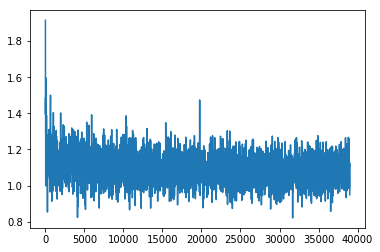

In [128]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

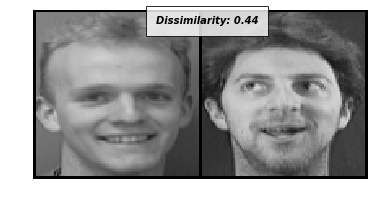

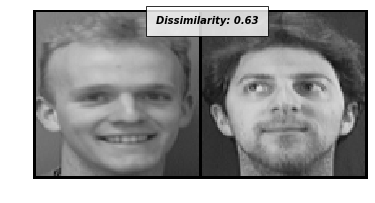

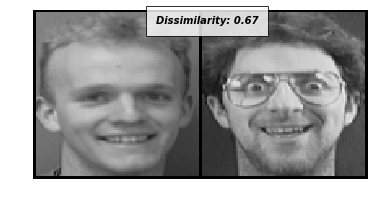

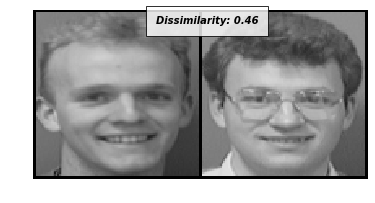

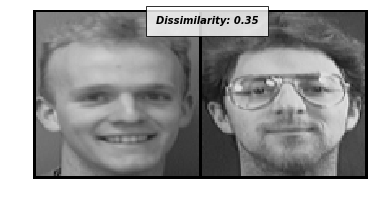

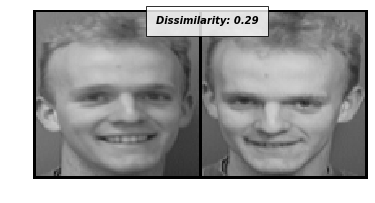

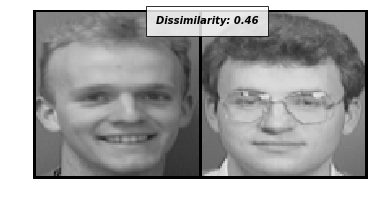

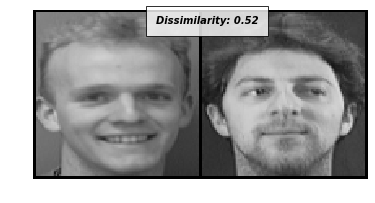

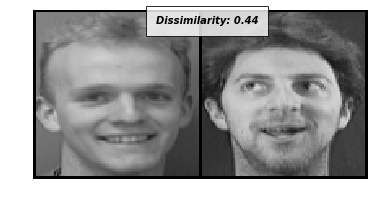

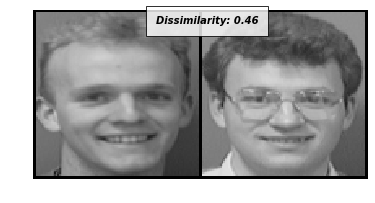

In [96]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir,
                                 transform=transforms.Compose([
                                     transforms.Grayscale(),
                                     transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                 ]))
siamese_dataset_test = SiameseNetworkDataset(folder_dataset_test)

test_dataloader = DataLoader(siamese_dataset_test, num_workers=6, batch_size=1, shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

